# Proyecto aplicado: "Pokemon_data"
* Andrés Forero
* Daniel Cuellar
* Daniela González 




## Librerías 
______

In [11]:
# manejo de data
import pandas as pd
import numpy as np


# visualización
import seaborn as sns
import matplotlib.pyplot as plt



# Metodología CRISP-DM
___
<img src="http://www.iic.uam.es/wp-content/uploads/2021/11/CRISP-DM.jpg" width="400" height="400" />


## Situación actual


## Descripción del dataset
_______________


## Problema
_____


## Objetivos
_____

### General


### Específico 



## Hipótesis (científica o estadística)
------


# Entendimiento de los datos
----

## Carga De Datos
------

In [179]:
data = pd.read_csv("pokemon.csv")

## Describir los datos 
------

Este conjunto de datos contiene información sobre los 802 Pokémon de las Siete Generaciones de Pokémon, y el cual contiene las siguientes características.


Name: El nombre en inglés del Pokémon.
Japanese_name: El nombre japonés original del Pokémon
Pokedex_number: El número de entrada del Pokémon en el Pokédex Nacional
Percent_male: El porcentaje de las especies que son machos. En blanco si el Pokémon no tiene género.
Type1: El tipo primario del Pokémon
Type2: El tipo secundario del Pokémon
Clasificación: La clasificación de los Pokémon como se describe en el Sol y la Luna Pokédex
Height_m: Altura del Pokémon en metros
Weight_kg: El Peso del Pokémon en kilogramos
Capture_rate: Tasa de captura del Pokémon
Base_egg_steps: La cantidad de pasos necesarios para eclosionar un huevo del Pokémon
Abilities:Lista ordenada de habilidades que el Pokémon es capaz de tener.
Experience_growth: El crecimiento de la experiencia de los Pokémon
Base_happiness: Felicidad Base del Pokémon
Against_?: dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
HP: El HP (Puntos de vida) base del Pokémon
Attack:El Ataque Base de los Pokémon
Defense:La Defensa Base de los Pokémon
Sp_attack: El Ataque Especial Base del Pokémon
Sp_defense: La Defensa Especial Base del Pokémon
Speed:La velocidad base del Pokémon
Generation: Generación numerada en la que se introdujo por primera vez el Pokémon
Is_legendary:Indica si el Pokémon es legendario.

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [163]:
data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [234]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

height_m      20
type2        384
weight_kg     20
dtype: int64

Pokemón sin sexo

In [265]:
data[data.weight_kg.isnull()][["name","weight_kg","height_m"] ]

,name,weight_kg,height_m
18,Rattata,NaN,NaN
19,Raticate,NaN,NaN
25,Raichu,NaN,NaN
26,Sandshrew,NaN,NaN
27,Sandslash,NaN,NaN
36,Vulpix,NaN,NaN
37,Ninetales,NaN,NaN
49,Diglett,NaN,NaN
50,Dugtrio,NaN,NaN
51,Meowth,NaN,NaN


In [252]:
b=data["weight_kg"]== 
b.value_counts()

weight_kg
False    801
Name: count, dtype: int64

Se crea una columna adicional para el porcentaje de sexo femenino, por ende, para los pokemón que no poseen sexo, se dejan en 0 las 2 columnas de sexo.

In [184]:
data["percentage_female"]= [ 100-i for i in data.percentage_male]
data["percentage_female"]=data["percentage_female"].fillna(0)
data["percentage_male"]=data["percentage_male"].fillna(0)

### Descarte de variables

Se descartan las siguientes variables:
* abilitites: están fuera del alcance.
* classfication: no provee mucha información.
* japanese_name: se va a trabajar con el nombre en inglés "name".
* pokedex_number: al ser un índice no da información adicional.
* type2: la mayoría de registros son de 1 solo tipo por ende se deja fuera del alcance.

In [210]:
# data["abilities","classfication","japanese_name","pokedex_number","type2"]

datos = data.loc[:,~data.columns.isin(["abilities","classfication","japanese_name","pokedex_number","type2"])]

## Estadística exploratoria
------

In [211]:
categorical_data = data.select_dtypes(include=['object']).columns
def est_exploratoria(data,categoricas):
    """
    tablas de estadística exploratoria
    ---
    data : dataframe
    categoricas : lista con nombre de variables a tratar como categoricas
    
    """
    datos = data.loc[:,~data.columns.isin(categoricas)]

    df0 = datos.agg([lambda x : sum(x.isna()),"count",]).rename(index={"<lambda>": 'Na count'})
    df1 = datos.agg(["mean"])
    df2 = datos.agg(pd.Series.mode).loc[[0]].rename(index={0: 'mode'})
    df3 = datos.agg(["median","std","var","kurt","skew","max","min"])

    df = pd.concat([df0,df1,df2, df3])

    df["Measurement"] = df.index
    df["Type"]=["Structure","Structure","Central t.","Central t.","Central t.","Dispersion","Dispersion","Shape","Shape","Range","Range"]
    df.set_index("Type", append=False, inplace=True)
    df.set_index("Measurement", append=True, inplace=True)

    numerica=df.round(decimals=2)

    datos = data.loc[:,data.columns.isin(categoricas)]


    df0 = datos.agg([lambda x : sum(x.isna())]).rename(index={"<lambda>": 'Na count'})

    df = pd.concat([df0,datos.describe(include=['object',"string"])])

    categorica=df.round(decimals=2)
    return numerica, categorica

numerica, categorica = est_exploratoria(datos,categorical_data)

numerica


against_bug  against_dark  against_dragon   
Type       Measurement                                              
Structure  Na count            0.00          0.00            0.00  \
           count             801.00        801.00          801.00   
Central t. mean                1.00          1.06            0.97   
           mode                1.00          1.00            1.00   
           median              1.00          1.00            1.00   
Dispersion std                 0.60          0.44            0.35   
           var                 0.36          0.19            0.12   
Shape      kurt                5.00          5.41            4.45   
           skew                1.76          1.72            0.00   
Range      max                 4.00          4.00            2.00   
           min                 0.25          0.25            0.00   

                        against_electric  against_fairy  against_fight   
Type       Measurement                                                   
Structure  Na count                 0.00           0.00           0.00  \
           count                  801.00         801.00         801.00   
Central t. mean                     1.07           1.07           1.07   
           mode                     1.00           1.00           1.00   
           median                   1.00           1.00           1.00   
Dispersion std                      0.65           0.52           0.72   
           var                      0.43           0.27           0.51   
Shape      kurt                     2.11           9.83           2.68   
           skew                     0.93           2.48           1.26   
Range      max                      4.00           4.00           4.00   
           min                      0.00           0.25           0.00   

                        against_fire  against_flying  against_ghost   
Type       Measurement                                                
Structure  Na count             0.00            0.00           0.00  \
           count              801.00          801.00         801.00   
Central t. mean                 1.14            1.19           0.99   
           mode                 1.00            1.00           1.00   
           median               1.00            1.00           1.00   
Dispersion std                  0.69            0.60           0.56   
           var                  0.48            0.37           0.31   
Shape      kurt                 3.75            5.06           2.03   
           skew                 1.61            1.77           0.45   
Range      max                  4.00            4.00           4.00   
           min                  0.25            0.25           0.00   

                        against_grass  ...  height_m      hp  percentage_male   
Type       Measurement                 ...                                      
Structure  Na count              0.00  ...     20.00    0.00             0.00  \
           count               801.00  ...    781.00  801.00           801.00   
Central t. mean                  1.03  ...      1.16   68.96            48.41   
           mode                  1.00  ...      0.60   60.00            50.00   
           median                1.00  ...      1.00   65.00            50.00   
Dispersion std                   0.79  ...      1.08   26.58            26.22   
           var                   0.62  ...      1.17  706.28           687.31   
Shape      kurt                  4.59  ...     43.10    8.33            -0.03   
           skew                  1.97  ...      5.08    1.83            -0.33   
Range      max                   4.00  ...     14.50  255.00           100.00   
           min                   0.25  ...      0.10    1.00             0.00   

                        sp_attack  sp_defense   speed  weight_kg  generation   
Type       Measurement                                                         
Structure  Na count      

In [189]:
categorica

,capture_rate,name,type1
Na count,0,0,0
count,801,801,801
unique,34,801,18
top,45,Bulbasaur,water
freq,250,1,114


## Visualización de datos
------

C:\Users\andre\AppData\Local\Temp\ipykernel_25028\2099431093.py:5: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.




<Axes: ylabel='Density'>

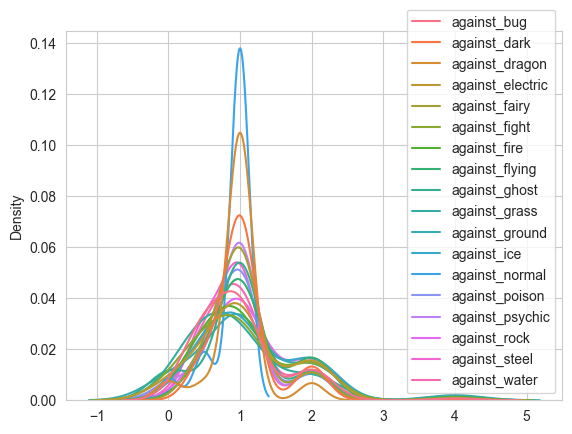

In [226]:
a=datos[datos.columns[pd.Series(datos.columns).str.startswith('against')]]


sns.set_style('whitegrid')
sns.kdeplot(a, bw=0.5)

In [323]:
contras1=datos[datos.columns[
    (pd.Series(datos.columns).str.startswith('against')) | 
    (datos.columns=="type1")]].groupby(["type1"]).agg("mean")

contras=contras1
contras.reset_index(inplace=True)

contras=pd.melt(contras, id_vars='type1')
contras.head()

,type1,variable,value
0,bug,against_bug,0.826389
1,dark,against_bug,1.724138
2,dragon,against_bug,0.944444
3,electric,against_bug,0.871795
4,fairy,against_bug,0.472222


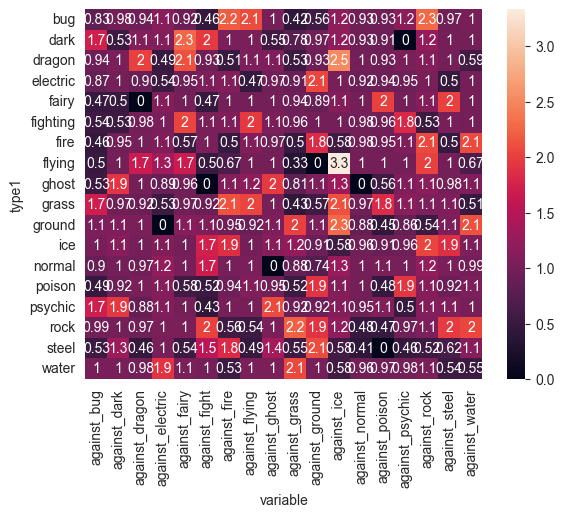

In [325]:
df_heatmap = contras.pivot_table(values='value',index='type1',columns='variable',aggfunc=np.mean)
sns.heatmap(df_heatmap,annot=True)
plt.show()

In [327]:
import plotly.express as px
fig = px.imshow(contras1)
# fig.update_xaxes(side="top")
fig.show()

AttributeError: 'tuple' object has no attribute 'set_xticklabels'

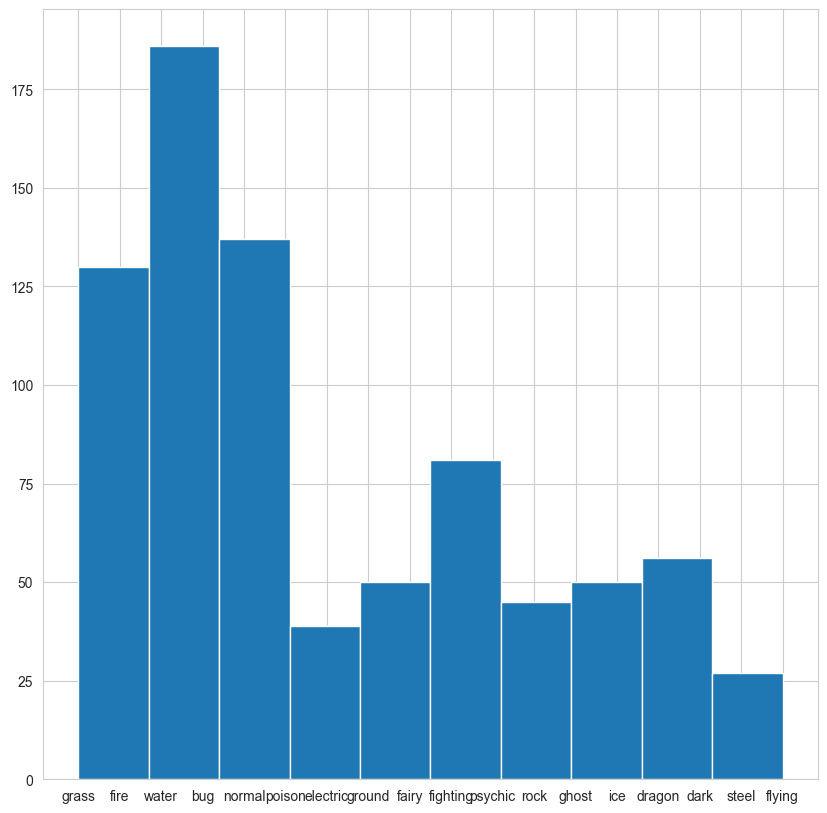

In [328]:
#tipos = datos["type1"].unique()

fig, axs = plt.subplots(figsize=(10, 10))
axs=plt.hist(datos["type1"])


# axs.set_xlabel("Tipo de Pokemón")
# axs.set_ylabel("Frecuencia")
# plt.show()

In [155]:
datos.type1.unique()

array(['grass', 'fire', 'water', 'bug', 'normal', 'poison', 'electric',
       'ground', 'fairy', 'fighting', 'psychic', 'rock', 'ghost', 'ice',
       'dragon', 'dark', 'steel', 'flying'], dtype=object)

# Preparación de datos
---

## Análisis de datos faltantes e imputaciones
----

In [ ]:
# datos fuera de rango
print("Fuera de rango RestingBP : ",data[(data["RestingBP"]<60) | (data["RestingBP"]>200)].shape[0])
print("Fuera de rango Cholesterol : ",data[(data["Cholesterol"]<120) | (data["Cholesterol"]>600)].shape[0])
print("Fuera de rango Oldpeak : ",data[(data["Oldpeak"]<0) | (data["Oldpeak"]>6.2)].shape[0])


Fuera de rango RestingBP :  1
Fuera de rango Cholesterol :  179
Fuera de rango Oldpeak :  13


## Filtros
----

Como se explica en la sección anterior, se filtran los registros con caracterísitcas fuera de rango (escala común).

In [ ]:
print("Longitud original:",data.shape[0])

data_fixed = data[(data["RestingBP"]>=60) & (data["RestingBP"]<=200) &
     (data["Cholesterol"]>=120) & (data["Cholesterol"]<=600) & 
     (data["Oldpeak"]>=0) & (data["Oldpeak"]<=6.2)]

print("Registros eliminados:",data.shape[0]-data_fixed.shape[0])
print("Nueva longitud:",data_fixed.shape[0])

Longitud original: 918
Registros eliminados: 180
Nueva longitud: 738


## Agrupaciones
----

In [ ]:
data_fixed.groupby(["Sex","HeartDisease"]).agg(["mean","size"]).round(2)

Age      RestingBP      Cholesterol        MaxHR       \
                   mean size      mean size        mean size    mean size   
Sex HeartDisease                                                            
F   0             51.12  142    128.77  142      249.18  142  149.18  142   
    1             56.02   40    143.38   40      279.18   40  139.25   40   
M   0             49.65  245    131.00  245      234.24  245  149.05  245   
    1             55.78  311    135.53  311      248.13  311  129.58  311   

                 Oldpeak       
                    mean size  
Sex HeartDisease               
F   0               0.44  142  
    1               1.47   40  
M   0               0.37  245  
    1               1.45  311

Parece existir una diferencia entre las medias de las variables dado el sexo y si padecen enfermedad cardíaca, se procederá a analizar si realmente son significativas estas diferencias.

## Construccion de tablas pivote y crosstab
----

Tras ver la relación del *MaxHR* por *RestingECG* en el análisis gráfico, se desea ver el valor medio separado por el clasificador principal *HeartDisease*.

In [ ]:
data_fixed.pivot_table(index="ChestPainType",columns="HeartDisease",values="MaxHR",aggfunc="mean").round(2)

HeartDisease,0,1
ChestPainType,,
ASY,139.52,128.17
ATA,152.90,141.52
NAP,151.78,134.98
TA,150.50,147.73


* Se puede observar una menor media de "MaxHR" si el paciente padece enfermedad cardíaca, esto, para cada categoría de "ChestPainType".

# Análisis de datos


## Pruebas de correlación
----


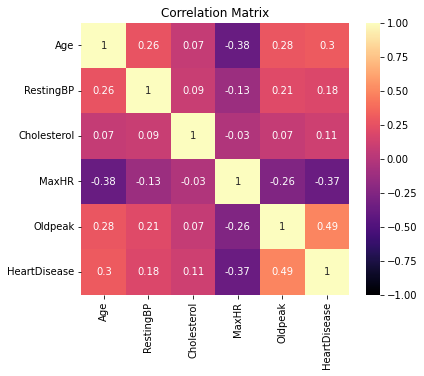

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax = sns.heatmap(data_fixed.corr().round(2),cmap='magma',vmin=-1,annot=True)
ax.set_title("Correlation Matrix");

In [ ]:

def tabla_corr_pearson(data_fixed,alfa,umbral):
  newdf = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
  result = []


  for i in newdf.columns:
    for j in newdf.columns:
      if i!=j:
        coef, p = stats.pearsonr(newdf[i], newdf[j])
        result.append([i,j,coef,p < alfa,p])

  correlaciones = pd.DataFrame(result,columns=["Var_i","Var_j","Coef_corr","Correlacionada","p_value"])


  return correlaciones[(correlaciones.Correlacionada==True) & (abs(correlaciones.Coef_corr)>=umbral)].drop_duplicates(["Coef_corr","p_value"])


tabla_corr_pearson(data_fixed,0.05,0.25)

,Var_i,Var_j,Coef_corr,Correlacionada,p_value
0,Age,RestingBP,0.263209,True,3.682124e-13
2,Age,MaxHR,-0.380071,True,8.926298e-27
3,Age,Oldpeak,0.282540,True,5.180863e-15
4,Age,HeartDisease,0.296911,True,1.739944e-16
18,MaxHR,Oldpeak,-0.256683,True,1.439216e-12
19,MaxHR,HeartDisease,-0.374328,True,5.813654e-26
24,Oldpeak,HeartDisease,0.491489,True,3.851994e-46


## Construcción de intervalos de confianza
----

In [ ]:
def limite_confianza_por_heartdisease(data, variable, confianza):

  
  limite_inferior_0, limite_superior_0 = sm.stats.DescrStatsW(data.loc[data.HeartDisease==0,variable]).tconfint_mean(alpha = 1-confianza)
  mean_0 = data.loc[data.HeartDisease==0,variable].mean()
  limite_inferior_1, limite_superior_1 = sm.stats.DescrStatsW(data.loc[data.HeartDisease==1,variable]).tconfint_mean(alpha = 1-confianza)
  mean_1 = data.loc[data.HeartDisease==1,variable].mean()
    
  result = pd.DataFrame([[variable,
                          [limite_inferior_0.round(4),mean_0.round(4),limite_superior_0.round(4)],
                          [limite_inferior_1.round(4),mean_1.round(4),limite_superior_1.round(4)]]],
                        columns=["variable","LI media LS hd:0","LI media LS hd:1"])
  return result.round(2)

tabla_medias=pd.DataFrame(columns=["variable","LI media LS hd:0","LI media LS hd:1"])

variables = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.drop("HeartDisease")

for i in variables:
    tabla_medias = tabla_medias.append(limite_confianza_por_heartdisease(data_fixed,i, 0.95))

display(tabla_medias)

,variable,LI media LS hd:0,LI media LS hd:1
0,Age,"[49.2611, 50.1912, 51.1213]","[54.8947, 55.812, 56.7292]"
0,RestingBP,"[128.5664, 130.1835, 131.8005]","[134.5531, 136.4245, 138.2959]"
0,Cholesterol,"[234.2843, 239.7261, 245.1679]","[245.5678, 251.6667, 257.7655]"
0,MaxHR,"[146.7832, 149.1008, 151.4184]","[128.3254, 130.6781, 133.0308]"
0,Oldpeak,"[0.3293, 0.3972, 0.465]","[1.3294, 1.4501, 1.5708]"


> **_Nota:_**  hd: HeartDisease.

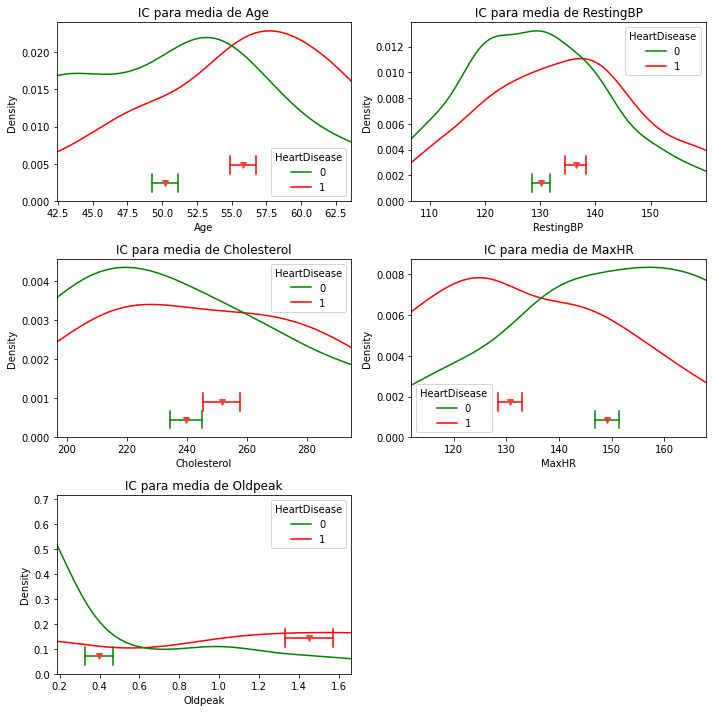

In [ ]:
fig,ax = plt.subplots(figsize=(10,10),nrows=3,ncols=2)

n=0
for i in range(3):
    for j in range(2):
        if n < len(variables):    
            lim=limite_confianza_por_heartdisease(data_fixed,variables[n], 0.95)
            sns.kdeplot(ax=ax[i,j],data=data_fixed, x=variables[n],hue="HeartDisease",palette=["green","red"])


            li_0 =lim.iloc[0][1][0]
            med_0 =lim.iloc[0][1][1]
            ls_0 =lim.iloc[0][1][2]

            li_1 =lim.iloc[0][2][0]
            med_1 =lim.iloc[0][2][1]
            ls_1 =lim.iloc[0][2][2]

            centro = (med_0+med_1)/2

            if variables[n]=="Oldpeak":
                ax[i,j].set_xlim([centro*0.20,centro*1.80])
            else:
                ax[i,j].set_xlim([centro*0.80,centro*1.20])

            #intervalo de confianza para hd:0
            color="green"
            ax[i,j].plot([li_0, ls_0], [ax[i,j].get_ylim()[1]*0.1, ax[i,j].get_ylim()[1]*0.1],color=color)
            ax[i,j].plot(med_0, ax[i,j].get_ylim()[1]*0.1, 'v', color='#f44336')
            ax[i,j].plot([li_0, li_0], [ax[i,j].get_ylim()[1]*0.05, ax[i,j].get_ylim()[1]*0.15],color=color)
            ax[i,j].plot([ls_0, ls_0], [ax[i,j].get_ylim()[1]*0.05, ax[i,j].get_ylim()[1]*0.15],color=color)


            #intervalo de confianza para hd:1
            color="red"
            ax[i,j].plot([li_1, ls_1], [ax[i,j].get_ylim()[1]*0.2, ax[i,j].get_ylim()[1]*0.2],color=color)
            ax[i,j].plot(med_1, ax[i,j].get_ylim()[1]*0.2, 'v', color='#f44336')
            ax[i,j].plot([li_1, li_1], [ax[i,j].get_ylim()[1]*0.15, ax[i,j].get_ylim()[1]*0.25],color=color)
            ax[i,j].plot([ls_1, ls_1], [ax[i,j].get_ylim()[1]*0.15, ax[i,j].get_ylim()[1]*0.25],color=color)

            ax[i,j].set_title(f"IC para media de {variables[n]}");
            n+=1

        else:
            ax[i,j].axis("off")

fig.tight_layout()

## Prueba de hipótesis
-----

In [ ]:
def test_hipotesis_dos_colas_por_heartdisease(data_fixed,variable):

    Categoria0 = data_fixed.loc[data_fixed.HeartDisease == 0,variable]
    Categoria1 = data_fixed.loc[data_fixed.HeartDisease == 1,variable]

    z, pvalor = sm.stats.ztest(Categoria0, Categoria1,value=0,alternative='two-sided')
    
    return z, pvalor, pvalor<0.05


def diferencia_medias(data):

    data=data_fixed

    result=[]

    columnas_numericas = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.drop("HeartDisease")

    for i in range(len(columnas_numericas)):

        value=test_hipotesis_dos_colas_por_heartdisease(data_fixed,columnas_numericas[i])
        result.append([columnas_numericas[i],value[0],value[1],value[2]])

    result = pd.DataFrame(result,columns=["Variable","z_score","p-value","Significativo"])

    return result.round(4)

print("Diferencia de medias por HeartDisease")
diferencia_medias(data_fixed)

Diferencia de medias por HeartDisease


,Variable,z_score,p-value,Significativo
0,Age,-8.4354,0.000,True
1,RestingBP,-4.9857,0.000,True
2,Cholesterol,-2.8818,0.004,True
3,MaxHR,10.9515,0.000,True
4,Oldpeak,-15.3106,0.000,True


In [ ]:
data_fixed.groupby(["HeartDisease"]).agg("mean").round(4)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
HeartDisease,,,,,
0,50.1912,130.1835,239.7261,149.1008,0.3972
1,55.8120,136.4245,251.6667,130.6781,1.4501


In [ ]:
def test_hipotesis_una_cola(variable,value,tipo):
    
    z, pvalor = sm.stats.ztest(variable,value=value,alternative=tipo)
    
    return z.round(4), pvalor.round(15), pvalor<0.05


result=[ 
test_hipotesis_una_cola(data_fixed.loc[data_fixed.HeartDisease==0,"Age"],
                        data_fixed.loc[data_fixed.HeartDisease==1,"Age"].mean(),
                        "smaller"),

test_hipotesis_una_cola(data_fixed.loc[data_fixed.HeartDisease==0,"RestingBP"],
                        data_fixed.loc[data_fixed.HeartDisease==1,"RestingBP"].mean(),
                        "smaller"),

test_hipotesis_una_cola(data_fixed.loc[data_fixed.HeartDisease==0,"Cholesterol"],
                        data_fixed.loc[data_fixed.HeartDisease==1,"Cholesterol"].mean(),
                        "smaller"),

test_hipotesis_una_cola(data_fixed.loc[data_fixed.HeartDisease==0,"MaxHR"],
                        data_fixed.loc[data_fixed.HeartDisease==1,"MaxHR"].mean(),
                        "larger"),

test_hipotesis_una_cola(data_fixed.loc[data_fixed.HeartDisease==0,"Oldpeak"],
                        data_fixed.loc[data_fixed.HeartDisease==1,"Oldpeak"].mean(),
                        "smaller")]

result = pd.DataFrame([["Age hd0 < Age hd1",result[0][0],result[0][1],result[0][2]],
["RestingBP hd0 < RestingBP hd1",result[1][0],result[1][1],result[1][2]],
["Cholesterol hd0 < Cholesterol hd1",result[2][0],result[2][1],result[2][2]],
["MaxHR hd0 > MaxHR hd1",result[3][0],result[3][1],result[3][2]],
["Oldpeak hd0 < Oldpeak hd1",result[4][0],result[4][1],result[4][2]]],
columns=["Hipótesis alterna","z_score","p_value","rechaza H0"])

result

,Hipótesis alterna,z_score,p_value,rechaza H0
0,Age hd0 < Age hd1,-11.8820,0.000000e+00,True
1,RestingBP hd0 < RestingBP hd1,-7.5883,1.600000e-14,True
2,Cholesterol hd0 < Cholesterol hd1,-4.3141,8.012261e-06,True
3,MaxHR hd0 > MaxHR hd1,15.6289,0.000000e+00,True
4,Oldpeak hd0 < Oldpeak hd1,-30.4969,0.000000e+00,True


## Gráficos avanzados
---

In [ ]:
variables_numericas = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.drop("HeartDisease")

variables_categoricas = data.columns[~data.columns.isin(cols_numericas)].drop("HeartDisease")


Tomando la variable "ChestPainType" se pueden observar que existe mayor cantidad de registros para asintomáticos enfermos.


## Transformación de variables categóricas a Dummy
---

In [ ]:
data_fixed = pd.get_dummies(data=data_fixed, columns=["Sex", "ChestPainType", "FastingBS","RestingECG","ExerciseAngina","ST_Slope"])

## Análisis de regresión y clasificación n-aria 
-----

### Modelo de regresión lineal

### Modelo de regresión logística

# Conclusiones
----